In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors

from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

# set pandas text output to 400
pd.options.display.max_colwidth = 400

In [2]:
data_train = pd.read_csv('my_train.csv') 
data_test = pd.read_csv('my_test.csv')
data_val= pd.read_csv('my_val.csv')

<Axes: xlabel='sentiment'>

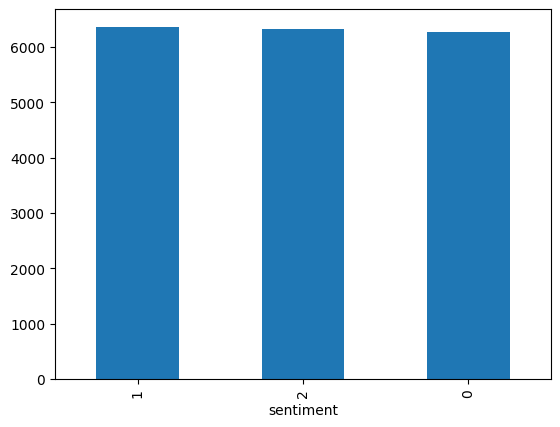

In [3]:
#check data_train
data_train['sentiment'].value_counts().plot(kind="bar")

# A little preprocessing

In [4]:
en_stopwords = stopwords.words('english')
#removing stopwords
data_train['text_clean'] = data_train['text'].apply( lambda x : ' '.join( [word for word in x.split() if word not in (en_stopwords)] ) )
data_val['text_clean'] = data_val['text'].apply( lambda x : ' '.join( [word for word in x.split() if word not in (en_stopwords)] ) )
data_test['text_clean'] = data_test['text'].apply( lambda x : ' '.join( [word for word in x.split() if word not in (en_stopwords)] ) )

In [ ]:
data_train.head(2)

,Unnamed: 0,sentiment,text,text_clean
0,12588,1,two rooms packed and cleaned three to go,two rooms packed cleaned three go
1,1079,0,_nation just launched twittix v1 10 not convinced,_nation launched twittix v1 10 convinced


In [6]:
#tokenize
sentences = [sentence.split() for sentence in data_train.text_clean]

# Now we implement different kind of technique to translate word into numbers...
| | VECTORIZING| EMBEDDING|
|--|---|--|
| GENERAL SCOPE| General conversion of data into numerical form|Specific focusing on capturing semantic relationship|
| METHOD| Count vectorization, TF-IDF| Word2Vec|
|GOAL|to make data suitable for mML algorithms|To capture the meaning and relationships within the data|

# 1. EMBEDDING 
An example of word embedding 

![word2vec main idea](https://miro.medium.com/v2/resize:fit:720/format:webp/1*Z-EOcLtUDlhvVuaruyM8EQ.png)
## 1.1 with a Word2vec embedding trained on training data

In [7]:
w2v_model = Word2Vec(sentences, vector_size= 300, window=5, min_count=4, workers=4)

#model.save("word2vec.model")
#model = Word2Vec.load("word2vec.model")

In [8]:
def vectorize(sentence, mymodel):
    words = sentence.split()
    vector_size= mymodel.vector_size
    #w2v_model.wv
    words_vecs = [mymodel[word] for word in words if word in mymodel]
    if len(words_vecs) == 0:
        return np.zeros(vector_size)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [9]:
X_train = np.array([vectorize(sentence, w2v_model.wv) for sentence in data_train.text_clean])
X_test = np.array([vectorize(sentence,w2v_model.wv) for sentence in data_test.text_clean])

In [10]:
X_train[0].shape

(300,)

In [11]:
y_train= data_train.sentiment
clf = SGDClassifier() #RandomForestClassifier(random_state=17, n_estimators= 100)#LogisticRegression() SVC(kernel='linear') 
clf.fit(X_train, y_train)

SGDClassifier()

In [12]:
y_test= data_test.sentiment
y_pred = clf.predict(X_test)
print('Accuracy:', round(accuracy_score(y_test, y_pred),2))

Accuracy: 0.36


Classification_report
              precision    recall  f1-score   support

           0       0.78      0.02      0.04      1792
           1       0.66      0.08      0.14      1731
           2       0.34      0.98      0.51      1747

    accuracy                           0.36      5270
   macro avg       0.60      0.36      0.23      5270
weighted avg       0.60      0.36      0.23      5270

Confusion Matrix


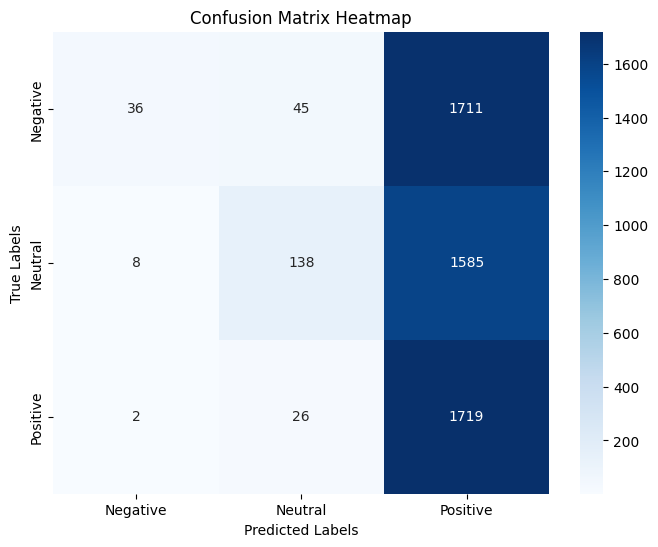

In [13]:
print(f'Classification_report')
print(classification_report(y_test,y_pred))
print(f'Confusion Matrix')
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Conclusion
This model is too optimist...

# 1. EMBEDDING 
 
## 1.2 Using a Pre Trained word2vec based on word2vec-google-news-300

In [14]:
#We can download our model and load
print(list(gensim.downloader.info()['models'].keys()))
#model = api.load('glove-twitter-200') #wv


['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [15]:
# Path to your pre-trained binary model file
model_path = 'GoogleNews-vectors-negative300.bin' 

# Load the pre-trained model
model = KeyedVectors.load_word2vec_format(model_path, binary=True) 

In [16]:
X_train = np.array([vectorize(sentence,model) for sentence in data_train.text_clean])
X_test = np.array([vectorize(sentence,model) for sentence in data_test.text_clean])

In [17]:
y_train= data_train.sentiment
clf = SGDClassifier()# RandomForestClassifier(random_state=17, n_estimators= 100) #SVC(kernel='linear')#LogisticRegression()  #LogisticRegression()
clf.fit(X_train, y_train)

SGDClassifier()

In [18]:
y_test= data_test.sentiment
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6891840607210626


Classification_report
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1792
           1       0.59      0.65      0.62      1731
           2       0.76      0.70      0.73      1747

    accuracy                           0.69      5270
   macro avg       0.69      0.69      0.69      5270
weighted avg       0.69      0.69      0.69      5270

Confusion Matrix


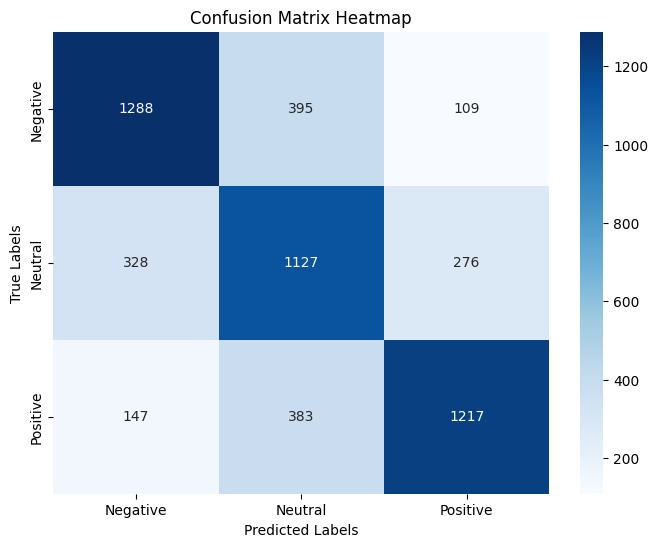

In [19]:
accuracy_score(y_test,y_pred)
print(f'Classification_report')
print(classification_report(y_test,y_pred))
print(f'Confusion Matrix')
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# 2. Vectorizing
## 2.1 Count vectorizing

![Count vectorizer example](https://miro.medium.com/v2/resize:fit:720/format:webp/1*RsrKmLuFVZcgZ3Z7sOzGKw.png)

In [20]:
countvec = CountVectorizer()

In [21]:
X_train = countvec.fit_transform(data_train.text_clean)
X_test = countvec.transform(data_test.text_clean)

In [22]:
y_train= data_train.sentiment
clf = SGDClassifier() #RandomForestClassifier(random_state=17, n_estimators= 100) #MultinomialNB() #SVC(kernel='linear')#LogisticRegression() 
clf.fit(X_train, y_train)

SGDClassifier()

In [30]:
y_test= data_test.sentiment
y_pred = clf.predict(X_test)
print('Accuracy:', round(accuracy_score(y_test, y_pred),3))

Accuracy: 0.702


Classification_report
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1792
           1       0.60      0.65      0.63      1731
           2       0.76      0.76      0.76      1747

    accuracy                           0.70      5270
   macro avg       0.70      0.70      0.70      5270
weighted avg       0.70      0.70      0.70      5270

Confusion Matrix


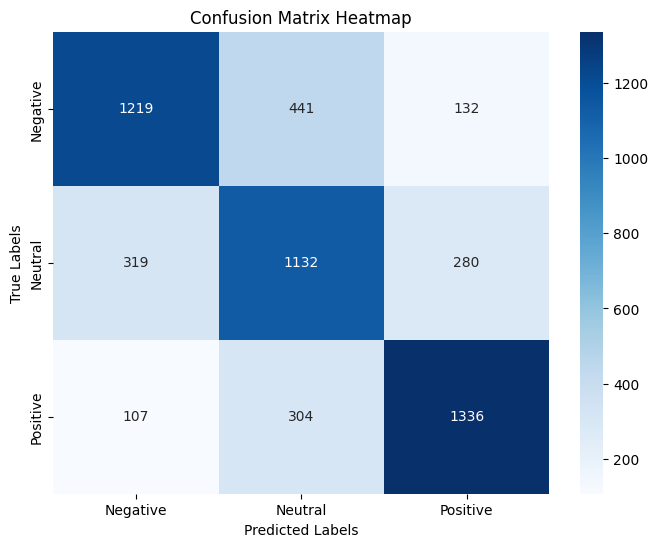

In [24]:
accuracy_score(y_test,y_pred)
print(f'Classification_report')
print(classification_report(y_test,y_pred))
print(f'Confusion Matrix')
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# 2.Vectorizing
## 2.2 TF-IDF

# TF-IDF vectorizing
**Term Frequency (TF)**

* **Definition:** The frequency of a term in a document. 

* **Formula:**

   $TF(t,d) = \frac{\text{Number of times term 't' appears in document 'd'}}{\text{Total number of terms in document 'd'}}$

   where:
     * $TF(t,d)$: Term Frequency of term 't' in document 'd'
     * 't': The term 
     * 'd': The document

**Inverse Document Frequency (IDF)**

* **Definition:** Measures the importance of a term across the entire corpus of documents. Rare terms are given higher weights.

* **Formula:**

   $IDF(t) = log \left( \frac{\text{Total number of documents}}{\text{Number of documents containing term 't'}} \right)$

   where:
     * $IDF(t)$: Inverse Document Frequency of term 't'
     * 't': The term
     * 'd': The document

**TF-IDF**

* **Definition:** Combines Term Frequency and Inverse Document Frequency to give higher weight to terms that are frequent in a document but rare in the corpus.

* **Formula:**

   $TF-IDF(t,d) = TF(t,d) * IDF(t)$

![Image Tfidf vectorizer](https://miro.medium.com/v2/resize:fit:720/format:webp/1*ALj6IYuGFr2PObkT5o1-rQ.png)

In [25]:
tfidfVEC = TfidfVectorizer()

In [26]:
X_train = tfidfVEC.fit_transform(data_train.text_clean)
X_test = tfidfVEC.transform(data_test.text_clean)

In [27]:
y_train= data_train.sentiment
clf = SGDClassifier() #MultinomialNB() #SVC(kernel='linear')#LogisticRegression() 
clf.fit(X_train, y_train)

SGDClassifier()

In [28]:
y_test= data_test.sentiment
y_pred = clf.predict(X_test)
print('Accuracy:', round(accuracy_score(y_test, y_pred),3))

Accuracy: 0.702


Classification_report
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1792
           1       0.62      0.63      0.62      1731
           2       0.75      0.77      0.76      1747

    accuracy                           0.70      5270
   macro avg       0.70      0.70      0.70      5270
weighted avg       0.70      0.70      0.70      5270

Confusion Matrix


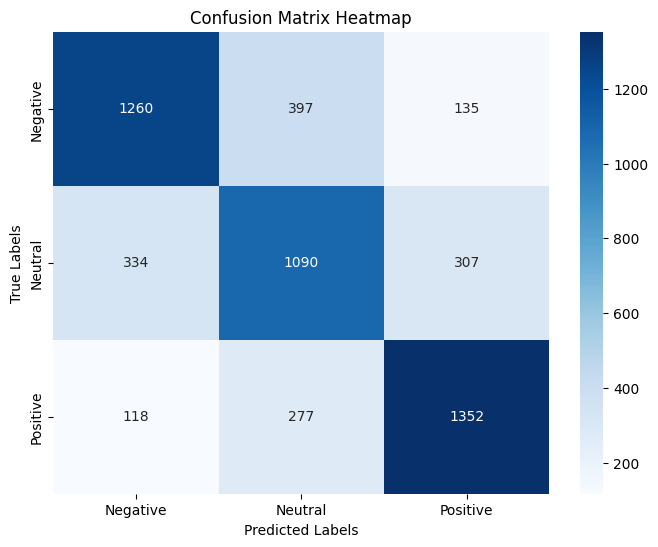

In [29]:
accuracy_score(y_test,y_pred)
print(f'Classification_report')
print(classification_report(y_test,y_pred))
print(f'Confusion Matrix')
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Conclusion

We test different ML algorithm for building our classifier
- LogistiRegression
- Stochastic Gradient Descent (SGD)
- Bernoulli Naive Bayes
- Support vector machine
- RandomForestRegressor

The best results came from **SGD**.

| | Accuracy | ML algorithm |
|-|-|-|
| Embedding (w2vec-training data)|  48%    | SGD |
| Embedding (w2vec pre-trained)|    64%    | SGD |
| CountVectorizer |                70.4%   | SGD |
| TF-IDF Vectorizer|               70.3%    | SGD |


# Bibliography
- [IDF Core concept: "A Statistical Interpretation of Term Specificity and Its Application in Retrieval" by Karen Spärck Jones (1972).](https://www.staff.city.ac.uk/~sbrp622/idfpapers/ksj_orig.pdf)
- [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#:~:text=A%20high%20weight%20in%20tf,in%20the%20whole%20collection%20of)
- [CountVectorizer vs TF-IDF](https://medium.com/@shandeep92/countvectorizer-vs-tfidfvectorizer-cf62d0a54fa4)

- [word2vec main paper: "Efficient Estimation of Word Representations in Vector Space" by Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean, 2013](https://arxiv.org/pdf/1301.3781)
- [The illustrated Word2vec, Jay Alammar](https://jalammar.github.io/illustrated-word2vec/)
- [Word2vec Embedding: a gentle introduction](https://towardsdatascience.com/understanding-word2vec-embedding-in-practice-3e9b8985953)
- [API gensim.Word2vec](https://radimrehurek.com/gensim/models/word2vec.html#:~:text=The%20trained%20word%20vectors%20can,wv.)